# Forward Kinematics
Primero se crea la cinemática directa, en esta podemos variar los ángulos del robotito que hemos armado para ver cómo joint por joint se efectúa el movimiento. Básicamente funciona
a partir de cómo definimos nuestra clase, inicializamos un robot (un brazo con una bifurcación y hacemos la visualización usando matplotlib).

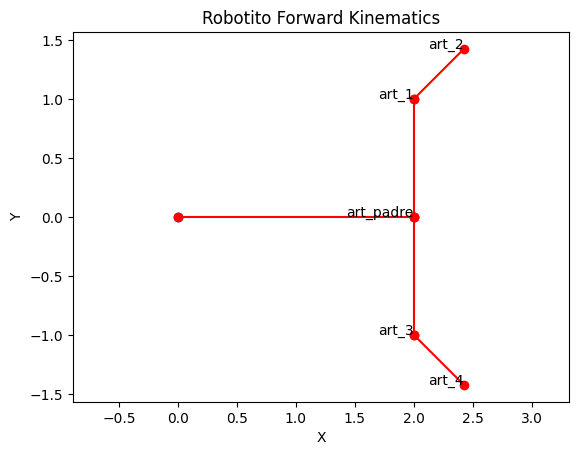

In [1]:
###DIRECTAAAAAAAAAAAA
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt

# Definimos nuestra clase robot con límites de ángulo
class robot:
    def __init__(self, nombre, longitud, angulo=0, padre=None, angulo_min=0, angulo_max=pi):
        self.nombre = nombre
        self.longitud = longitud # Longitud del joint (esta longitud es la distancia entre el joint y el siguiente joint)
        self.angulo = angulo # Ángulo del joint
        self.padre = padre # Nodo padre
        self.angulo_min = angulo_min  # Ángulo mínimo permitido
        self.angulo_max = angulo_max  # Ángulo máximo permitido
        self.punto_inicial = np.array([0, 0, 1])
        self.punto_final = np.array([0, 0, 1])

    def obtener_angulo_acumulado(self):
        angulo_acumulado = self.angulo
        nodo_actual = self.padre #se inicia en el nodo padre del brazo
        while nodo_actual is not None: #se itera hasta quedarnos sin nodos
            angulo_acumulado += nodo_actual.angulo
            nodo_actual = nodo_actual.padre #se mueve al siguiente nodo padre para poder recorrer el brazo
        return angulo_acumulado

    def calcular_posicion(self):
        if self.padre:
            self.punto_inicial = self.padre.punto_final #aquí hace al nodo padre el punto inicial para poder calcular la posición
        else:
            self.punto_inicial = np.array([0, 0, 1])

        angulo_acumulado = self.obtener_angulo_acumulado()
        T_rotacion = matriz_rotacion(angulo_acumulado) #manda a llamar a la matriz de rotación para aplicarlo al ángulo acumulado

        desplazamiento = np.array([self.longitud, 0, 1])
        punto_final_homogeneo = T_rotacion @ desplazamiento
        self.punto_final = self.punto_inicial[:2] + punto_final_homogeneo[:2]

        return self.punto_final
    #Funciones
def matriz_rotacion(angulo):
    return np.array([[cos(angulo), -sin(angulo), 0],
                     [sin(angulo), cos(angulo), 0],
                     [0, 0, 1]])

    # Función para dibujar el robot en el plano con etiquetas y bifurcación
def dibujar_robot(joints):
    plt.figure()
    # Dibujar el punto de origen
    plt.plot(0, 0, 'bo')  # Dibuja el origen (punto azul)

    for joint in joints:
        joint.calcular_posicion()
        # Dibuja una línea desde punto_inicial hasta punto_final
        plt.plot([joint.punto_inicial[0], joint.punto_final[0]],
                 [joint.punto_inicial[1], joint.punto_final[1]], 'ro-')

        # Etiqueta del joint
        plt.text(joint.punto_final[0], joint.punto_final[1], joint.nombre, fontsize=10, ha='right')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Robotito Forward Kinematics")
    plt.axis('equal')
    plt.show()

# Definición de los joints y objetivo
art_padre = robot("art_padre", 2, angulo=0)
#brazo 1
art_1 = robot("art_1", 1, angulo=pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_2 = robot("art_2", 0.6, angulo=-pi/4, padre=art_1, angulo_min = -2*pi/3, angulo_max = 2*pi/3)
#brazo 2
art_3 = robot("art_3", 1, angulo=-pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_4 = robot("art_4", 0.6, angulo=pi/4, padre=art_3,  angulo_min = -2*pi/3, angulo_max = 2*pi/3)

joints = [art_padre, art_1, art_2, art_3, art_4]
dibujar_robot(joints)
    ##FIN DE LA DIRECTAAA


# Inverse Kinematics

In [2]:
### todo esto funciona exactamente igual al chunk de código anterior, la única diferencia es que se vuelve a definir la misma clase pero con la primer R en mayúscula
# Definimos nuestra clase robot con límites de ángulo

class Robot:
    def __init__(self, nombre, longitud, angulo=0, padre=None, angulo_min=0, angulo_max=pi):
        self.nombre = nombre
        self.longitud = longitud
        self.angulo = angulo
        self.padre = padre
        self.angulo_min = angulo_min  # Ángulo mínimo permitido
        self.angulo_max = angulo_max  # Ángulo máximo permitido
        self.punto_inicial = np.array([0, 0, 1])
        self.punto_final = np.array([0, 0, 1])

    def obtener_angulo_acumulado(self):
        angulo_acumulado = self.angulo
        nodo_actual = self.padre
        while nodo_actual is not None:
            angulo_acumulado += nodo_actual.angulo
            nodo_actual = nodo_actual.padre
        return angulo_acumulado

    def calcular_posicion(self):
        if self.padre:
            self.punto_inicial = self.padre.punto_final
        else:
            self.punto_inicial = np.array([0, 0, 1])

        angulo_acumulado = self.obtener_angulo_acumulado()
        T_rotacion = matriz_rotacion(angulo_acumulado)

        desplazamiento = np.array([self.longitud, 0, 1])
        punto_final_homogeneo = T_rotacion @ desplazamiento
        self.punto_final = self.punto_inicial[:2] + punto_final_homogeneo[:2]

        return self.punto_final

    #todo esto funciona exactamente igual al chunk de código anterior

In [3]:
import imageio

In [6]:

#Funciones
def matriz_rotacion(angulo):
    return np.array([[cos(angulo), -sin(angulo), 0],
                     [sin(angulo), cos(angulo), 0],
                     [0, 0, 1]])

def proyeccion_nulo_jacobiano(J, J_pseudo):
    return np.eye(len(J_pseudo)) - J_pseudo @ J #tal y como en el artículo.

def actualizar_articulaciones(joints, Delta_theta): #aquí simplemente se actualizan los ángulos de los joints con el delta_theta calculado anteriormente,
    for i, joint in enumerate(joints):
        nuevo_angulo = joint.angulo + Delta_theta[i]
        # además usamos este if para simular que el joint tiene un límite en sus articulaciones
        if nuevo_angulo < joint.angulo_min:
            joint.angulo = joint.angulo_min
        elif nuevo_angulo > joint.angulo_max:
            joint.angulo = joint.angulo_max
        else:
            joint.angulo = nuevo_angulo
# Dibujar el robot en el plano en cada iteración
def dibujar_robot(joints, objetivo):
    plt.clf()
    plt.plot(0, 0, 'bo')  # Dibuja el origen (punto azul)
    plt.plot(objetivo[0], objetivo[1], 'go', label='Objetivo')  # Dibuja el objetivo (punto verde)

    for joint in joints:
        joint.calcular_posicion()
        plt.plot([joint.punto_inicial[0], joint.punto_final[0]],
                 [joint.punto_inicial[1], joint.punto_final[1]], 'ro-')
        plt.text(joint.punto_final[0], joint.punto_final[1], joint.nombre, fontsize=10, ha='right')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Movimiento del Robotito")
    plt.axis('equal')
    plt.legend()
    plt.pause(0.1)  # Pausar para visualizar el cambio en tiempo real



#a partir de aquí se define la función cinemática inversa que manda a llamar diversas funciones
def cinemática_inversa(joints, objetivo, gif_filename, tolerancia=0.01, max_iter=100):
    plt.figure()

    # Define los brazos como grupos de articulaciones incluyendo a art_padre para poder efectuar un movimiento por brazo (es decir en triadas de joints)
    brazos = [(joints[0], joints[1], joints[2]), (joints[0], joints[3], joints[4])]

    frames = []
    
    for iteracion in range(max_iter):
        # Calcula la posición del end-effector de cada brazo completo y encuentra el más cercano al objetivo
        distancias = []
        posiciones_efectores = []
        for brazo in brazos:
            posicion = brazo[-1].calcular_posicion()[:2]  # Posición del end-effector
            posiciones_efectores.append(posicion)
            distancias.append(np.linalg.norm(objetivo - posicion))

        # Selecciona el brazo más cercano al objetivo
        indice_brazo_mas_cercano = np.argmin(distancias)
        brazo_mas_cercano = brazos[indice_brazo_mas_cercano]
        posicion_end_effector = posiciones_efectores[indice_brazo_mas_cercano]
        print(f"Posición del end-effector: {posicion_end_effector}")
        print(f"Distancia al objetivo: {distancias[indice_brazo_mas_cercano]}")
        print(f"El end-effector más cercano es el del brazo: {indice_brazo_mas_cercano}")

        # Calcula el error de posición para acercarse al objetivo
        Delta_x = objetivo - posicion_end_effector
        if np.linalg.norm(Delta_x) < tolerancia:
            print(f"Objetivo alcanzado en la iteración {iteracion}")
            break

        # Construye el Jacobiano para el brazo más cercano
        J_brazo = np.zeros((2, len(brazo_mas_cercano)))
        for i, joint in enumerate(brazo_mas_cercano):
            angulo_acumulado = joint.obtener_angulo_acumulado()
            J_brazo[0, i] = -joint.longitud * np.sin(angulo_acumulado)
            J_brazo[1, i] = joint.longitud * np.cos(angulo_acumulado)

        # Calcula el cambio de ángulo (Delta_theta) con la pseudo-inversa
        J_pseudo_brazo = np.linalg.pinv(J_brazo)  #usa la función pinv de numpy para calcular la pseudo inversa de la matriz J (se había calculado la pseudo inversa explícita como en el artículo, pero era más sencillo usar la de numpy)
        #calculamos la proyección nula del Jacobiano
        P_N_de_J = np.eye(len(J_pseudo_brazo)) - J_pseudo_brazo @ J_brazo #tal y como en el artículo.
        #calculamos Delta_a (n-dimensional posture variation)
        factor_postura = 0.1  # Factor de escala para reducir el efecto de la variación de postura

        Delta_a = np.zeros(len(brazo_mas_cercano)) #este delta_A lo inicializamos a nuestra conveniencia, pues sin el factor postura el robot se volvía loco (además de que también corremos el codigo sin él)
        for i, joint in enumerate(brazo_mas_cercano):
            angulo_central = (joint.angulo_min + joint.angulo_max) / 2
            Delta_a[i] = factor_postura * (angulo_central - joint.angulo)


        Delta_theta = (J_pseudo_brazo @ Delta_x)  + (P_N_de_J @ Delta_a) #calculamos el cambio de ángulo con la fórmula del artículo

        # Aplica el cambio de ángulo a las articulaciones del brazo completo (incluyendo art_padre)
        actualizar_articulaciones(brazo_mas_cercano, Delta_theta)

        # Visualiza el estado actual del robot en esta iteración
        dibujar_robot(joints, objetivo)
        
        #guardamos el frame actual en memoria
        fig = plt.gcf()
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        frame = buf.reshape(h, w, 4)[:, :, :3]
        frames.append(frame.copy())

    plt.show()

    if frames:
        imageio.mimsave(gif_filename, frames, fps=10)  # 10 fps suele verse bien
        print(f"GIF guardado como: {gif_filename}")
    else:
        print("No se generaron frames; revisa el bucle/condición de parada.")


In [8]:

#Funciones
def matriz_rotacion(angulo):
    return np.array([[cos(angulo), -sin(angulo), 0],
                     [sin(angulo), cos(angulo), 0],
                     [0, 0, 1]])

def proyeccion_nulo_jacobiano(J, J_pseudo):
    return np.eye(len(J_pseudo)) - J_pseudo @ J #tal y como en el artículo.

def actualizar_articulaciones(joints, Delta_theta): #aquí simplemente se actualizan los ángulos de los joints con el delta_theta calculado anteriormente,
    for i, joint in enumerate(joints):
        nuevo_angulo = joint.angulo + Delta_theta[i]
        # además usamos este if para simular que el joint tiene un límite en sus articulaciones
        if nuevo_angulo < joint.angulo_min:
            joint.angulo = joint.angulo_min
        elif nuevo_angulo > joint.angulo_max:
            joint.angulo = joint.angulo_max
        else:
            joint.angulo = nuevo_angulo
# Dibujar el robot en el plano en cada iteración
def dibujar_robot(joints, objetivo, ax):
    ax.clear()
    ax.plot(0, 0, 'bo')  # Dibuja el origen (punto azul)
    ax.plot(objetivo[0], objetivo[1], 'go', label='Objetivo')  # Dibuja el objetivo (punto verde)

    for joint in joints:
        joint.calcular_posicion()
        ax.plot([joint.punto_inicial[0], joint.punto_final[0]],
                 [joint.punto_inicial[1], joint.punto_final[1]], 'ro-')
        ax.text(joint.punto_final[0], joint.punto_final[1], joint.nombre, fontsize=10, ha='right')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Movimiento del Robotito")
    ax.axis('equal')
    ax.legend()
    #plt.pause(0.1)  # Pausar para visualizar el cambio en tiempo real



#a partir de aquí se define la función cinemática inversa que manda a llamar diversas funciones
def cinemática_inversa(joints, objetivo, gif_filename, tolerancia=0.01, max_iter=100):
    fig, ax = plt.subplots(figsize=(6, 6))
    #estimamos un rango fijo de visualización
    L = 0.0
    for j in joints:
        L += getattr(j, "longitud", 0.0)
    R = max(1.0, L*0.6)
    ax.set_xlim(-R, R)
    ax.set_ylim(-R, R)

    # Define los brazos como grupos de articulaciones incluyendo a art_padre para poder efectuar un movimiento por brazo (es decir en triadas de joints)
    brazos = [(joints[0], joints[1], joints[2]), 
              (joints[0], joints[3], joints[4])]

    frames = []
    
    for iteracion in range(max_iter):
        # Calcula la posición del end-effector de cada brazo completo y encuentra el más cercano al objetivo
        distancias = []
        posiciones_efectores = []
        for brazo in brazos:
            posicion = brazo[-1].calcular_posicion()[:2]  # Posición del end-effector
            posiciones_efectores.append(posicion)
            distancias.append(np.linalg.norm(objetivo - posicion))

        # Selecciona el brazo más cercano al objetivo
        idx = int(np.argmin(distancias))
        brazo_mas_cercano = brazos[idx]
        posicion_end_effector = posiciones_efectores[idx]
        print(f"Posición del end-effector: {posicion_end_effector}")
        print(f"Distancia al objetivo: {distancias[idx]}")
        print(f"El end-effector más cercano es el del brazo: {idx}")

        # Calcula el error de posición para acercarse al objetivo
        Delta_x = objetivo - posicion_end_effector
        if np.linalg.norm(Delta_x) < tolerancia:
            print(f"Objetivo alcanzado en la iteración {iteracion}")
            #aun dibujamos el estado final
            dibujar_robot(joints, objetivo, ax=ax)
            fig.canvas.draw()
            w, h = fig.canvas.get_width_height()
            buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
            frame = buf.reshape(h, w, 4)[:, :, :3]
            frames.append(frame.copy())
            break

        # Construye el Jacobiano para el brazo más cercano
        J_brazo = np.zeros((2, len(brazo_mas_cercano)))
        for i, joint in enumerate(brazo_mas_cercano):
            angulo_acumulado = joint.obtener_angulo_acumulado()
            J_brazo[0, i] = -joint.longitud * np.sin(angulo_acumulado)
            J_brazo[1, i] = joint.longitud * np.cos(angulo_acumulado)

        # Calcula el cambio de ángulo (Delta_theta) con la pseudo-inversa
        J_pseudo_brazo = np.linalg.pinv(J_brazo)  #usa la función pinv de numpy para calcular la pseudo inversa de la matriz J (se había calculado la pseudo inversa explícita como en el artículo, pero era más sencillo usar la de numpy)
        #calculamos la proyección nula del Jacobiano
        P_N_de_J = np.eye(len(J_pseudo_brazo)) - J_pseudo_brazo @ J_brazo #tal y como en el artículo.
        #calculamos Delta_a (n-dimensional posture variation)
        factor_postura = 0.1  # Factor de escala para reducir el efecto de la variación de postura

        Delta_a = np.zeros(len(brazo_mas_cercano)) #este delta_A lo inicializamos a nuestra conveniencia, pues sin el factor postura el robot se volvía loco (además de que también corremos el codigo sin él)
        for i, joint in enumerate(brazo_mas_cercano):
            angulo_central = (joint.angulo_min + joint.angulo_max) / 2
            Delta_a[i] = factor_postura * (angulo_central - joint.angulo)


        Delta_theta = (J_pseudo_brazo @ Delta_x)  + (P_N_de_J @ Delta_a) #calculamos el cambio de ángulo con la fórmula del artículo

        # Aplica el cambio de ángulo a las articulaciones del brazo completo (incluyendo art_padre)
        actualizar_articulaciones(brazo_mas_cercano, Delta_theta)

        # Visualiza el estado actual del robot en esta iteración
        dibujar_robot(joints, objetivo, ax=ax)
        
        ax.set_xlim(-R, R)
        ax.set_ylim(-R, R)
        
        #guardamos el frame actual en memoria
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        frame = buf.reshape(h, w, 4)[:, :, :3]
        frames.append(frame.copy())

    plt.show()

    if frames:
        imageio.mimsave(gif_filename, frames, fps=10)  # 10 fps suele verse bien
        print(f"GIF guardado como: {gif_filename}")
    else:
        print("No se generaron frames; revisa el bucle/condición de parada.")


##prueba 1

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [0.42426407 0.42426407]
Distancia al objetivo: 1.9079181111925376
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.9133302  1.61940648]
Distancia al objetivo: 0.921102584181724
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.95503606 2.10344405]
Distancia al objetivo: 0.6051169163489006
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.36926148 1.55839049]
Distancia al objetivo: 0.3738495571400053
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.15217254 1.67637046]
Distancia al objetivo: 0.23294424111918868
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.09002889 1.59046235]
Distancia al objetivo: 0.12762694994481932
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.04230459 1.5684496 ]
Distancia al objetivo: 0.08046754767259923
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.03681498 1.5402944 ]
Distancia al objetivo: 0.0545800460424221
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.0308719  1.52685984]
Distancia al objetivo: 0.04092095870316546
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.03474149 1.51326783]
Distancia al objetivo: 0.03718879955567721
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.03549322 1.50553198]
Distancia al objetivo: 0.03592173767160536
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.03975876 1.49798867]
Distancia al objetivo: 0.03980959752409162
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.04016454 1.49404728]
Distancia al objetivo: 0.040603264057248296
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.04217706 1.49044775]
Distancia al objetivo: 0.043245233446741596
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.04076111 1.48918945]
Distancia al objetivo: 0.042170322158019344
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.04030826 1.48825125]
Distancia al objetivo: 0.04198557681615869
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02248218 1.5090024 ]
Distancia al objetivo: 0.024217584647082603
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.02074767 1.53569641]
Distancia al objetivo: 0.04128800724887824
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02120039 1.55651252]
Distancia al objetivo: 0.060358273683728605
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02040637 1.57255449]
Distancia al objetivo: 0.07536958147038797
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02006487 1.58437705]
Distancia al objetivo: 0.08672995487236328
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01939365 1.59256194]
Distancia al objetivo: 0.09457180533378902
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.01877199 1.5975459 ]
Distancia al objetivo: 0.09933574533287991
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01803018 1.59973059]
Distancia al objetivo: 0.10134731675715106
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01725125 1.5994723 ]
Distancia al objetivo: 0.10095714055527878
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01640404 1.59710557]
Distancia al objetivo: 0.09848139406555055
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01551196 1.59294799]
Distancia al objetivo: 0.09423348418198296
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.0145774  1.58730454]
Distancia al objetivo: 0.08851318317048634
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.0136152  1.58046797]
Distancia al objetivo: 0.08161169183755634
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01263716 1.57271669]
Distancia al objetivo: 0.07380660003816493
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01165773 1.56431153]
Distancia al objetivo: 0.06535958415219194
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01069033 1.5554919 ]
Distancia al objetivo: 0.05651225272217892
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.00974777 1.54647228]
Distancia al objetivo: 0.04748359303125017
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.00884105 1.53743942]
Distancia al objetivo: 0.03846913704341253
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.00797922 1.52855087]
Distancia al objetivo: 0.029644902900236497
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.00716902 1.51993465]
Distancia al objetivo: 0.021184551892336756
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.00641495 1.51169023]
Distancia al objetivo: 0.013334651689668001
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.00571941 1.50389046]
Distancia al objetivo: 0.006917173358024914
El end-effector más cercano es el del brazo: 0
Objetivo alcanzado en la iteración 37


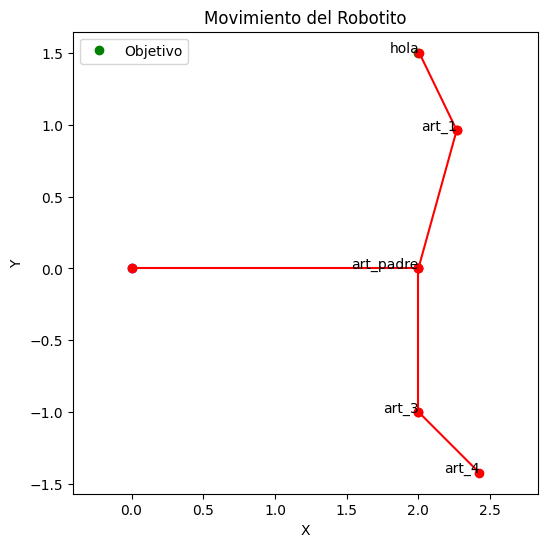

GIF guardado como: animacion_robot.gif


In [9]:
# Definición de los joints y objetivo
art_padre = Robot("art_padre", 2, angulo=0)
#brazo 1
art_1 = Robot("art_1", 1, angulo=pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_2 = Robot("hola", 0.6, angulo=-pi/4, padre=art_1, angulo_min = -2*pi/3, angulo_max = 2*pi/3)
#brazo 2
art_3 = Robot("art_3", 1, angulo=-pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_4 = Robot("art_4", 0.6, angulo=pi/4, padre=art_3,  angulo_min = -2*pi/3, angulo_max = 2*pi/3)

joints = [art_padre, art_1, art_2, art_3, art_4]
objetivo = np.array([2, 1.5])  # Define el objetivo deseado

# Ejecutar la cinemática inversa con visualización en cada iteración
cinemática_inversa(joints, objetivo, gif_filename="animacion_robot.gif")

##prueba 2

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [0.42426407 0.42426407]
Distancia al objetivo: 2.22842712474619
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.46038806 2.27231065]
Distancia al objetivo: 0.5348927481430971
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.81036484 2.24132011]
Distancia al objetivo: 0.3069151182416799
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.12855617 1.91549602]
Distancia al objetivo: 0.15384281267250136
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01206741 2.05650086]
Distancia al objetivo: 0.05777516576182474
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.05956462 2.00334436]
Distancia al objetivo: 0.059658429267564
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.04164306 2.02979355]
Distancia al objetivo: 0.05120351810970981
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.04968036 2.0255637 ]
Distancia al objetivo: 0.05587164736755159
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.04512207 2.032727  ]
Distancia al objetivo: 0.05574098294556865
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.04371554 2.03427918]
Distancia al objetivo: 0.05555277218789422
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.03959813 2.03616914]
Distancia al objetivo: 0.05363038870419701
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.03594221 2.03563633]
Distancia al objetivo: 0.0506141356272859
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.03222302 2.03361982]
Distancia al objetivo: 0.04656839415464012
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02944093 2.02981587]
Distancia al objetivo: 0.04190172498469712
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.02766686 2.02476251]
Distancia al objetivo: 0.03712999944526079
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02708985 2.01887553]
Distancia al objetivo: 0.03301735911159139
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02743563 2.01281091]
Distancia al objetivo: 0.03027925364964942
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02837891 2.00709625]
Distancia al objetivo: 0.029252684236594582
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02947274 2.00215849]
Distancia al objetivo: 0.029551672922046593
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.03039621 1.9981975 ]
Distancia al objetivo: 0.030449611329264287
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.03090554 1.99526842]
Distancia al objetivo: 0.03126563936249609
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.03090993 1.99329635]
Distancia al objetivo: 0.031628512178144996
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.03038882 1.99215667]
Distancia al objetivo: 0.03138468451948938
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02940536 1.99169333]
Distancia al objetivo: 0.030556110477476323
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.02804276 1.99175613]
Distancia al objetivo: 0.02922940355498849
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02640823 1.99220395]
Distancia al objetivo: 0.027534945030757145
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02459823 1.99291702]
Distancia al objetivo: 0.02559768178530644
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02270302 1.9937949 ]
Distancia al objetivo: 0.02353572587045203
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.02079311 1.99475849]
Distancia al objetivo: 0.02144356891716744
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.0189244  1.99574702]
Distancia al objetivo: 0.019396414286036365
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01713569 1.99671623]
Distancia al objetivo: 0.01744749011527844
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01545308 1.99763542]
Distancia al objetivo: 0.015632947960252788
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01389146 1.99848488]
Distancia al objetivo: 0.013973839279727849
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [2.01245758 1.99925337]
Distancia al objetivo: 0.012479934600127095
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01115207 1.99993605]
Distancia al objetivo: 0.011152250834982745
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.00997136 2.00053264]
Distancia al objetivo: 0.009985575014467125
El end-effector más cercano es el del brazo: 0
Objetivo alcanzado en la iteración 35


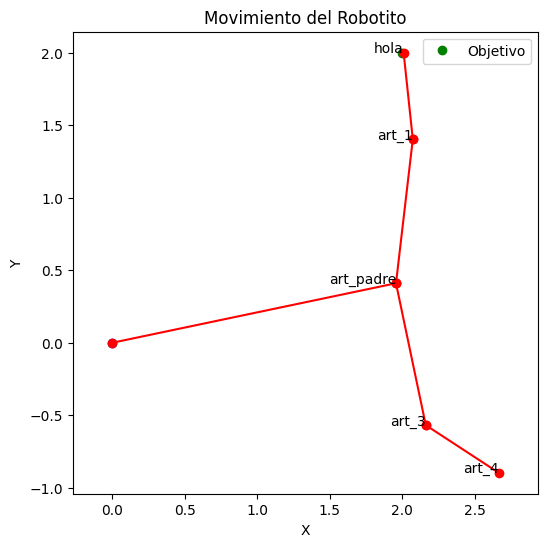

GIF guardado como: animacion_robot2.gif


In [10]:
# Definición de los joints y objetivo
art_padre = Robot("art_padre", 2, angulo=0)
#brazo 1
art_1 = Robot("art_1", 1, angulo=pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_2 = Robot("hola", 0.6, angulo=-pi/4, padre=art_1, angulo_min = -2*pi/3, angulo_max = 2*pi/3)
#brazo 2
art_3 = Robot("art_3", 1, angulo=-pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_4 = Robot("art_4", 0.6, angulo=pi/4, padre=art_3,  angulo_min = -2*pi/3, angulo_max = 2*pi/3)

joints = [art_padre, art_1, art_2, art_3, art_4]
objetivo = np.array([2, 2])  # Define el objetivo deseado

# Ejecutar la cinemática inversa con visualización en cada iteración
cinemática_inversa(joints, objetivo, gif_filename="animacion_robot2.gif")

#prueba 3

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [0.42426407 0.42426407]
Distancia al objetivo: 2.891366458960192
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [0.4475354  0.08426079]
Distancia al objetivo: 3.108132278075626
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.21993024 0.78950777]
Distancia al objetivo: 3.439947992915237
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [ 1.39607751 -0.10472631]
Distancia al objetivo: 3.9953992607323294
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [-1.70497607  1.56859339]
Distancia al objetivo: 0.5226382879285811
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-1.49490516  2.31045184]
Distancia al objetivo: 0.5928753169280201
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-2.09648553  1.68350922]
Distancia al objetivo: 0.33087137965538527
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-1.80096972  2.2378586 ]
Distancia al objetivo: 0.3101447506723373
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-2.07905559  1.85325236]
Distancia al objetivo: 0.16668729722280876
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [-1.91175602  2.16884361]
Distancia al objetivo: 0.19051290322617337
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-2.03823518  1.92987557]
Distancia al objetivo: 0.07987093123444534
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-1.94888781  2.12626801]
Distancia al objetivo: 0.1362206545558813
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-2.01068524  1.97111757]
Distancia al objetivo: 0.030795599010974083
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-1.96993538  2.08789851]
Distancia al objetivo: 0.09289795139516253
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [-1.99770146  1.99765531]
Distancia al objetivo: 0.003283421687328262
El end-effector más cercano es el del brazo: 0
Objetivo alcanzado en la iteración 14


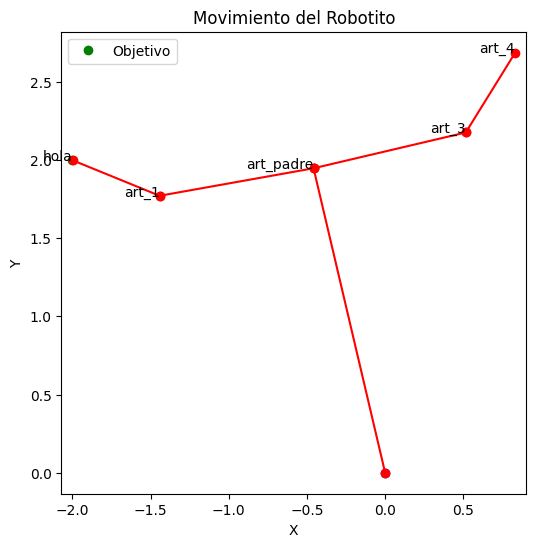

GIF guardado como: animacion_robot3.gif


In [11]:
# Definición de los joints y objetivo
art_padre = Robot("art_padre", 2, angulo=0)
#brazo 1
art_1 = Robot("art_1", 1, angulo=pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_2 = Robot("hola", 0.6, angulo=-pi/4, padre=art_1, angulo_min = -2*pi/3, angulo_max = 2*pi/3)
#brazo 2
art_3 = Robot("art_3", 1, angulo=-pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_4 = Robot("art_4", 0.6, angulo=pi/4, padre=art_3,  angulo_min = -2*pi/3, angulo_max = 2*pi/3)

joints = [art_padre, art_1, art_2, art_3, art_4]
objetivo = np.array([-2, 2])  # Define el objetivo deseado

# Ejecutar la cinemática inversa con visualización en cada iteración
cinemática_inversa(joints, objetivo, gif_filename="animacion_robot3.gif")

#prueba 4

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [0.42426407 0.42426407]
Distancia al objetivo: 2.272211197303694
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-0.36669256  1.67379726]
Distancia al objetivo: 0.8368881857496224
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-0.19899503  2.60976346]
Distancia al objetivo: 0.3203935206295227
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [-0.57965832  2.29177994]
Distancia al objetivo: 0.22293729856622513
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-0.3945301   2.61887675]
Distancia al objetivo: 0.15892004777483107
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-0.5186889   2.44684446]
Distancia al objetivo: 0.05634524254997903
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-0.4734092   2.54286611]
Distancia al objetivo: 0.05044377042334001
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [-0.49754446  2.49960705]
Distancia al objetivo: 0.0024867835351110815
El end-effector más cercano es el del brazo: 0
Objetivo alcanzado en la iteración 7


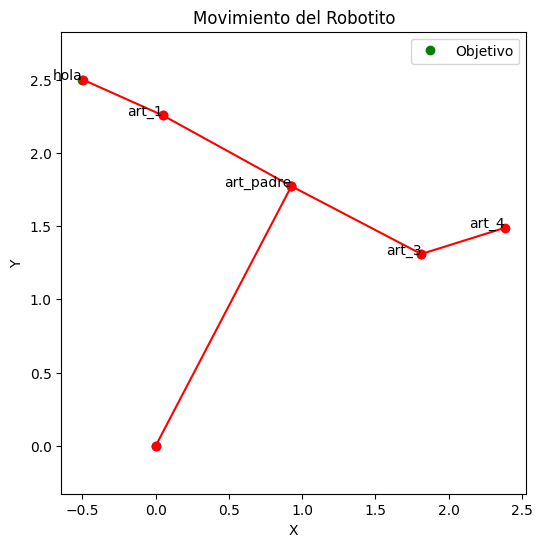

GIF guardado como: animacion_robot4.gif


In [12]:
# Definición de los joints y objetivo
art_padre = Robot("art_padre", 2, angulo=0)
#brazo 1
art_1 = Robot("art_1", 1, angulo=pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_2 = Robot("hola", 0.6, angulo=-pi/4, padre=art_1, angulo_min = -2*pi/3, angulo_max = 2*pi/3)
#brazo 2
art_3 = Robot("art_3", 1, angulo=-pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_4 = Robot("art_4", 0.6, angulo=pi/4, padre=art_3,  angulo_min = -2*pi/3, angulo_max = 2*pi/3)

joints = [art_padre, art_1, art_2, art_3, art_4]
objetivo = np.array([-0.5, 2.5])  # Define el objetivo deseado

# Ejecutar la cinemática inversa con visualización en cada iteración
cinemática_inversa(joints, objetivo, gif_filename="animacion_robot4.gif")

#prueba 5

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [ 0.42426407 -0.42426407]
Distancia al objetivo: 1.8027360168647188
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [3.32693387 0.3650735 ]
Distancia al objetivo: 2.129136736074755
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [ 2.72118165 -0.48979285]
Distancia al objetivo: 1.0846836410849208
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [ 2.2125501  -0.84547173]
Distancia al objetivo: 0.5017703555814229
El end-effector más cercano es el del brazo: 1


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [ 1.95308223 -1.02813919]
Distancia al objetivo: 0.27587964630405826
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [ 2.03161923 -1.17488164]
Distancia al objetivo: 0.12905184398873254
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [ 2.02779986 -1.26420643]
Distancia al objetivo: 0.045321204018121695
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [ 2.08632143 -1.25913791]
Distancia al objetivo: 0.09550444322747981
El end-effector más cercano es el del brazo: 1


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [ 2.04318371 -1.2806178 ]
Distancia al objetivo: 0.04733394829367412
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [ 2.0717674 -1.2727157]
Distancia al objetivo: 0.07677885456919283
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [ 2.03531895 -1.28429407]
Distancia al objetivo: 0.038653648170352925
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [ 2.04453197 -1.28548036]
Distancia al objetivo: 0.04683925619287973
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [ 2.02590188 -1.29126821]
Distancia al objetivo: 0.027334074860059378
El end-effector más cercano es el del brazo: 1


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [ 2.02555352 -1.29415797]
Distancia al objetivo: 0.026212812891503613
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [ 2.01780217 -1.29678507]
Distancia al objetivo: 0.01809013999532377
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [ 2.01512091 -1.29860648]
Distancia al objetivo: 0.015184991374911035
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [ 2.01165722 -1.29978381]
Distancia al objetivo: 0.011659222508425094
El end-effector más cercano es el del brazo: 1
Posición del end-effector: [ 2.00943053 -1.30058575]
Distancia al objetivo: 0.009448708031782542
El end-effector más cercano es el del brazo: 1
Objetivo alcanzado en la iteración 17


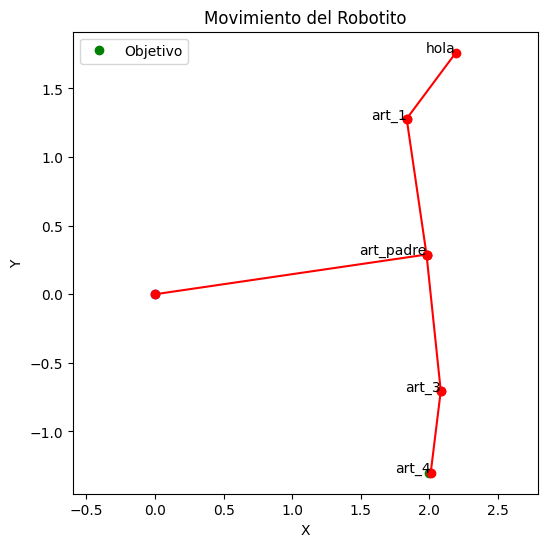

GIF guardado como: animacion_robot5.gif


In [13]:
# Definición de los joints y objetivo
art_padre = Robot("art_padre", 2, angulo=0)
#brazo 1
art_1 = Robot("art_1", 1, angulo=pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_2 = Robot("hola", 0.6, angulo=-pi/4, padre=art_1, angulo_min = -2*pi/3, angulo_max = 2*pi/3)
#brazo 2
art_3 = Robot("art_3", 1, angulo=-pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_4 = Robot("art_4", 0.6, angulo=pi/4, padre=art_3,  angulo_min = -2*pi/3, angulo_max = 2*pi/3)

joints = [art_padre, art_1, art_2, art_3, art_4]
objetivo = np.array([2, -1.3])  # Define el objetivo deseado

# Ejecutar la cinemática inversa con visualización en cada iteración
cinemática_inversa(joints, objetivo, gif_filename="animacion_robot5.gif")

#prueba 6

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [0.42426407 0.42426407]
Distancia al objetivo: 0.814213562373095
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.69193204 1.83530172]
Distancia al objetivo: 1.8868924143471093
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [0.54543686 0.39162783]
Distancia al objetivo: 0.7594368602896032
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.31152615 0.72811963]
Distancia al objetivo: 0.4134821379084773
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [0.98267074 0.87478866]
Distancia al objetivo: 0.1264048423213008
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.17583825 1.05812509]
Distancia al objetivo: 0.18519615634774308
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.01291845 1.07036368]
Distancia al objetivo: 0.07153973572757936
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.08645898 1.18324886]
Distancia al objetivo: 0.20262107563601411
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.02868898 1.19648559]
Distancia al objetivo: 0.19856898708510548
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.04758023 1.24349725]
Distancia al objetivo: 0.24810238150492012
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.02886006 1.25316779]
Distancia al objetivo: 0.25480744219763396
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.0303074  1.26724701]
Distancia al objetivo: 0.2689600432699623
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.02322005 1.26704284]
Distancia al objetivo: 0.26805046443332076
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.020551   1.26351381]
Distancia al objetivo: 0.2643139606568962
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.01656652 1.253617  ]
Distancia al objetivo: 0.25415749570446
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.01358996 1.24047069]
Distancia al objetivo: 0.2408543921997876
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.01075787 1.22463271]
Distancia al objetivo: 0.22489016397303668
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00840877 1.20756812]
Distancia al objetivo: 0.20773836960713996
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.0064392  1.19023075]
Distancia al objetivo: 0.19033970156134228
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00486186 1.17348294]
Distancia al objetivo: 0.17355105361915507
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00362667 1.15790971]
Distancia al objetivo: 0.15795134691987578
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00268403 1.14387629]
Distancia al objetivo: 0.1439013253152951
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.00197773 1.1315475 ]
Distancia al objetivo: 0.1315623640211586
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00145592 1.12093837]
Distancia al objetivo: 0.1209471286566444
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00107376 1.11196118]
Distancia al objetivo: 0.11196632985052869
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00079511 1.1044675 ]
Distancia al objetivo: 0.10447052265619095
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00059202 1.09828032]
Distancia al objetivo: 0.09828210033991185
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.00044361 1.09321661]
Distancia al objetivo: 0.09321766139846352
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00033463 1.08910146]
Distancia al objetivo: 0.08910208712932068
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00025409 1.08577595]
Distancia al objetivo: 0.08577633092066017
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00019413 1.0831006 ]
Distancia al objetivo: 0.08310082925585799
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00014915 1.08095597]
Distancia al objetivo: 0.0809561051817075
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.00011516 1.07924164]
Distancia al objetivo: 0.07924172794523604
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00008929 1.07787438]
Distancia al objetivo: 0.07787442884271392
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00006949 1.07678586]
Distancia al objetivo: 0.07678588787647217
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00005424 1.07592048]
Distancia al objetivo: 0.07592049999159804
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00004245 1.07523328]
Distancia al objetivo: 0.07523329025520682
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.00003328 1.07468805]
Distancia al objetivo: 0.0746880579106089
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00002614 1.07425577]
Distancia al objetivo: 0.07425577493977263
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00002056 1.07391323]
Distancia al objetivo: 0.07391323392520815
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00001619 1.07364192]
Distancia al objetivo: 0.07364192413944001
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00001276 1.07342711]
Distancia al objetivo: 0.07342710807787943
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.00001006 1.07325707]
Distancia al objetivo: 0.07325706924646445
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000794 1.0731225 ]
Distancia al objetivo: 0.07312250347662162
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000627 1.07301603]
Distancia al objetivo: 0.07301602886992992
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000495 1.07293179]
Distancia al objetivo: 0.07293179279295539
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.00000391 1.07286516]
Distancia al objetivo: 0.0728651576587767
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000309 1.07281245]
Distancia al objetivo: 0.07281245029515672
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000244 1.07277076]
Distancia al objetivo: 0.07277076240174421
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000193 1.07273779]
Distancia al objetivo: 0.07273779191287189
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000152 1.07271172]
Distancia al objetivo: 0.072711717024244
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.0000012 1.0726911]
Distancia al objetivo: 0.07269109624762794
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000095 1.07267479]
Distancia al objetivo: 0.07267478917178727
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000075 1.07266189]
Distancia al objetivo: 0.07266189367477983
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.0000006 1.0726517]
Distancia al objetivo: 0.07265169619391006
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000047 1.07264363]
Distancia al objetivo: 0.07264363235141824
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.00000037 1.07263726]
Distancia al objetivo: 0.07263725578799086
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000029 1.07263221]
Distancia al objetivo: 0.07263221349843355
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000023 1.07262823]
Distancia al objetivo: 0.07262822631631992
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000018 1.07262507]
Distancia al objetivo: 0.07262507347478162
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000015 1.07262258]
Distancia al objetivo: 0.0726225803933758
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.00000012 1.07262061]
Distancia al objetivo: 0.07262060901772666
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000009 1.07261905]
Distancia al objetivo: 0.07261905017888536
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000007 1.07261782]
Distancia al objetivo: 0.07261781755045223
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000006 1.07261684]
Distancia al objetivo: 0.07261684286954623
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000004 1.07261607]
Distancia al objetivo: 0.07261607215741932
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.00000004 1.07261546]
Distancia al objetivo: 0.07261546273069079
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000003 1.07261498]
Distancia al objetivo: 0.07261498083786189
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000002 1.0726146 ]
Distancia al objetivo: 0.07261459979032299
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000002 1.0726143 ]
Distancia al objetivo: 0.07261429848441504
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.00000001 1.07261406]
Distancia al objetivo: 0.0726140602327392
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000001 1.07261387]
Distancia al objetivo: 0.07261387184000373
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000001 1.07261372]
Distancia al objetivo: 0.07261372287226395
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000001 1.07261361]
Distancia al objetivo: 0.07261360507906188
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.00000001 1.07261351]
Distancia al objetivo: 0.0726135119365041
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.         1.07261344]
Distancia al objetivo: 0.07261343828594637
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261338]
Distancia al objetivo: 0.07261338004829118
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261333]
Distancia al objetivo: 0.07261333399807372
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.        1.0726133]
Distancia al objetivo: 0.07261329758482196
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261327]
Distancia al objetivo: 0.07261326879180131
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.         1.07261325]
Distancia al objetivo: 0.07261324602432097
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261323]
Distancia al objetivo: 0.07261322802141112
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261321]
Distancia al objetivo: 0.07261321378598695
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.        1.0726132]
Distancia al objetivo: 0.07261320252962244
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261319]
Distancia al objetivo: 0.07261319362888785
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.         1.07261319]
Distancia al objetivo: 0.07261318659081839
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261318]
Distancia al objetivo: 0.07261318102561187
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261318]
Distancia al objetivo: 0.07261317662504263
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261317]
Distancia al objetivo: 0.07261317314538318
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261317]
Distancia al objetivo: 0.07261317039391635
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.         1.07261317]
Distancia al objetivo: 0.07261316821825159
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261317]
Distancia al objetivo: 0.07261316649788996
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261317]
Distancia al objetivo: 0.0726131651375499
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261316]
Distancia al objetivo: 0.07261316406188989
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.         1.07261316]
Distancia al objetivo: 0.07261316321133449
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261316]
Distancia al objetivo: 0.07261316253877514
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261316]
Distancia al objetivo: 0.07261316200696344
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261316]
Distancia al objetivo: 0.07261316158644382
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.         1.07261316]
Distancia al objetivo: 0.07261316125392692
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.         1.07261316]
Distancia al objetivo: 0.07261316099099702
El end-effector más cercano es el del brazo: 0


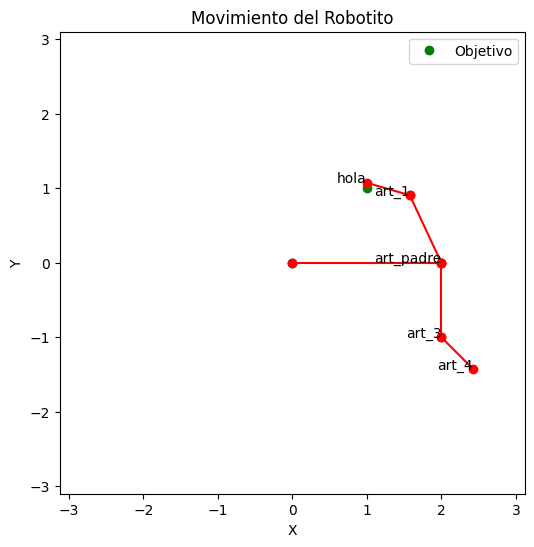

GIF guardado como: animacion_robot6.gif


In [14]:
# Definición de los joints y objetivo
art_padre = Robot("art_padre", 2, angulo=0)
#brazo 1
art_1 = Robot("art_1", 1, angulo=pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_2 = Robot("hola", 0.6, angulo=-pi/4, padre=art_1, angulo_min = -2*pi/3, angulo_max = 2*pi/3)
#brazo 2
art_3 = Robot("art_3", 1, angulo=-pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_4 = Robot("art_4", 0.6, angulo=pi/4, padre=art_3,  angulo_min = -2*pi/3, angulo_max = 2*pi/3)

joints = [art_padre, art_1, art_2, art_3, art_4]
objetivo = np.array([1, 1])  # Define el objetivo deseado

# Ejecutar la cinemática inversa con visualización en cada iteración
cinemática_inversa(joints, objetivo, gif_filename="animacion_robot6.gif")

#prueba 7

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [0.21213203 0.21213203]
Distancia al objetivo: 1.5097482665067639
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.1616064  1.54421031]
Distancia al objetivo: 1.1624474088392578
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.01095779 2.13415549]
Distancia al objetivo: 0.6342501549848265
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.02713868 1.73696988]
Distancia al objetivo: 0.23851883098351953
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [0.91270377 1.51988011]
Distancia al objetivo: 0.08953127884784585
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.14208165 1.5530884 ]
Distancia al objetivo: 0.15167587690883727
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [0.9466083  1.44953852]
Distancia al objetivo: 0.07346451410923872
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.14122559 1.55776569]
Distancia al objetivo: 0.15258290545674152
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [0.96558857 1.4504263 ]
Distancia al objetivo: 0.0603464853517255
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.09489693 1.55443287]
Distancia al objetivo: 0.10940002507528437
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [0.98927352 1.47415583]
Distancia al objetivo: 0.02798175341578044
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.04519405 1.53566741]
Distancia al objetivo: 0.05757313530096843
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.003637  1.4960386]
Distancia al objetivo: 0.005377775921519672
El end-effector más cercano es el del brazo: 0
Objetivo alcanzado en la iteración 12


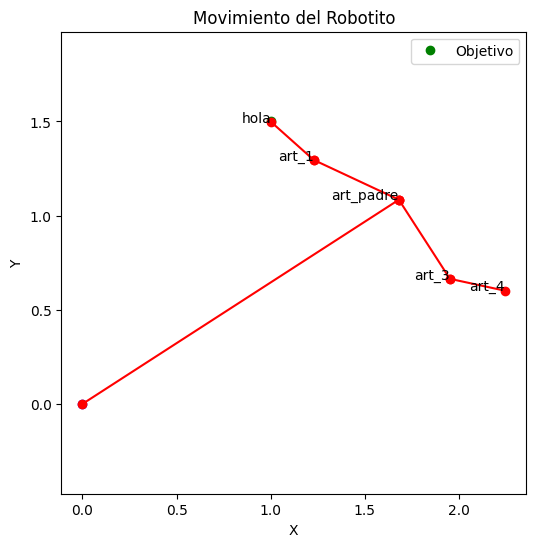

GIF guardado como: animacion_robot7.gif


In [15]:
# Definición de los joints y objetivo
art_padre = Robot("art_padre", 2, angulo=0)
#brazo 1
art_1 = Robot("art_1", 0.5, angulo=pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_2 = Robot("hola", 0.3, angulo=-pi/4, padre=art_1, angulo_min = -2*pi/3, angulo_max = 2*pi/3)
#brazo 2
art_3 = Robot("art_3", 0.5, angulo=-pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_4 = Robot("art_4", 0.3, angulo=pi/4, padre=art_3,  angulo_min = -2*pi/3, angulo_max = 2*pi/3)

joints = [art_padre, art_1, art_2, art_3, art_4]
objetivo = np.array([1, 1.5])  # Define el objetivo deseado

# Ejecutar la cinemática inversa con visualización en cada iteración
cinemática_inversa(joints, objetivo, gif_filename="animacion_robot7.gif")

#prueba 8

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [0.42426407 0.42426407]
Distancia al objetivo: 1.9079181111925376
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.42088935 1.97375862]
Distancia al objetivo: 0.748208778730507
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.95485595 0.91337407]
Distancia al objetivo: 0.5883604078194281
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.75374235 1.80040088]
Distancia al objetivo: 0.38843727783905413
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.01926098 1.27221035]
Distancia al objetivo: 0.22860251169253218
El end-effector más cercano es el del brazo: 0


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Posición del end-effector: [1.93946739 1.57665851]
Distancia al objetivo: 0.09767662585976777
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [2.0044577  1.44699147]
Distancia al objetivo: 0.05319563133863914
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.98801774 1.51031814]
Distancia al objetivo: 0.015812606983911116
El end-effector más cercano es el del brazo: 0
Posición del end-effector: [1.99218591 1.49688645]
Distancia al objetivo: 0.0084115456520154
El end-effector más cercano es el del brazo: 0
Objetivo alcanzado en la iteración 8


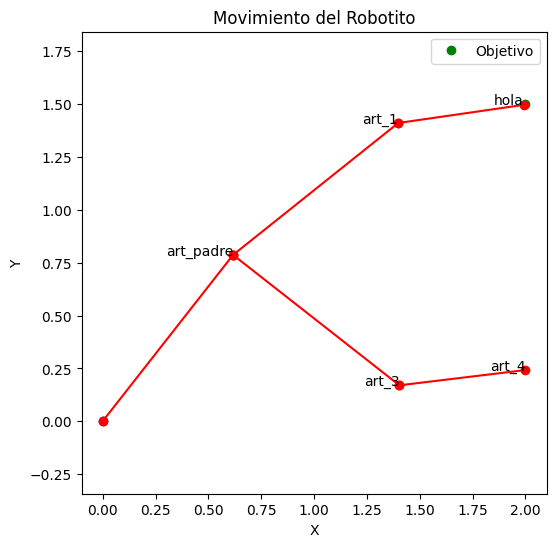

GIF guardado como: animacion_robot8.gif


In [16]:
# Definición de los joints y objetivo
art_padre = Robot("art_padre", 1, angulo=0)
#brazo 1
art_1 = Robot("art_1", 1, angulo=pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_2 = Robot("hola", 0.6, angulo=-pi/4, padre=art_1, angulo_min = -2*pi/3, angulo_max = 2*pi/3)
#brazo 2
art_3 = Robot("art_3", 1, angulo=-pi/2, padre=art_padre,  angulo_min = -pi, angulo_max = pi)
art_4 = Robot("art_4", 0.6, angulo=pi/4, padre=art_3,  angulo_min = -2*pi/3, angulo_max = 2*pi/3)

joints = [art_padre, art_1, art_2, art_3, art_4]
objetivo = np.array([2, 1.5])  # Define el objetivo deseado

# Ejecutar la cinemática inversa con visualización en cada iteración
cinemática_inversa(joints, objetivo, gif_filename="animacion_robot8.gif")